In [1]:
from configparser import ConfigParser, ExtendedInterpolation
import os

import h5py
from ipywidgets import IntSlider, interact, Dropdown
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.io import loadmat

%matplotlib notebook
config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('../../config.ini')

['../../config.ini']

## Plot map and raw temporal profile

In [2]:
# Parameters
processed_file = config['FILES']['processed']
output_file = os.path.join(config['REPORT']['sta'], 'maps/')
if not os.path.exists(output_file):
    os.makedirs(output_file)

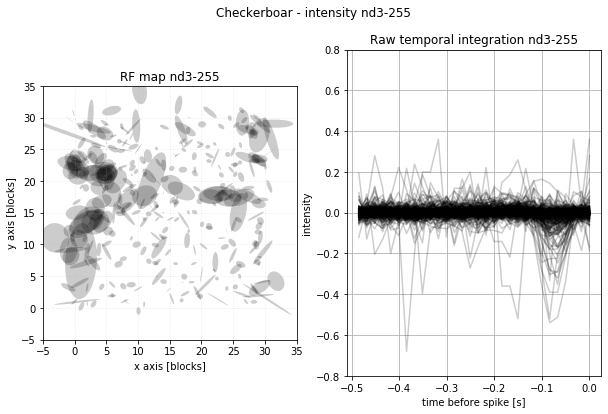

In [3]:
intensities = ['nd3-255',]



with h5py.File(processed_file,'r') as protocols:
    for intensity in intensities:
        fig, (ax_map, ax_traw) = plt.subplots(1,2, figsize=(10, 6))
        fig.suptitle('Checkerboar - intensity {}'.format(intensity))
        spatial_group = '/sta/{}/spatial/char/'.format(intensity)
        temporal_group = '/sta/{}/temporal/raw/'.format(intensity)
        raw_group = '/sta/{}/raw/'.format(intensity)
        time_raw_temp = protocols[f'/sta/{intensity}/temporal/raw/'].attrs['time']
#         valid_group = '/sta/{}/valid/'.format(intensity)
        
        for key in protocols[spatial_group]:
            angle, a, b, x0, y0, snr, frame = protocols[spatial_group+key][...]
            traw = protocols[temporal_group+key][:]
            pellipse = patches.Ellipse((x0, y0), a*2, b*2, angle=angle, facecolor='k', alpha=0.2, edgecolor='none')
            ax_map.add_patch(pellipse)
            # ax.annotate(kchar['name'],xy=(x0,y0),fontsize=7, color=np.random.rand(3,))
            ax_traw.plot(time_raw_temp, traw, alpha=0.2, c='k')

        ax_traw.set(xlabel='time before spike [s]', ylabel='intensity',
                    ylim=[-0.8,0.8], title='Raw temporal integration '+intensity)
        ax_traw.grid()
        ax_map.set(xlim=[-5,35], ylim=[-5,35], xlabel='x axis [blocks]',
               ylabel='y axis [blocks]', aspect=1, title='RF map '+intensity)
        ax_map.grid(alpha=0.3,linestyle=':')
        fig.savefig(output_file + 'map_and_raw_temporal_{}.png'.format(intensity))


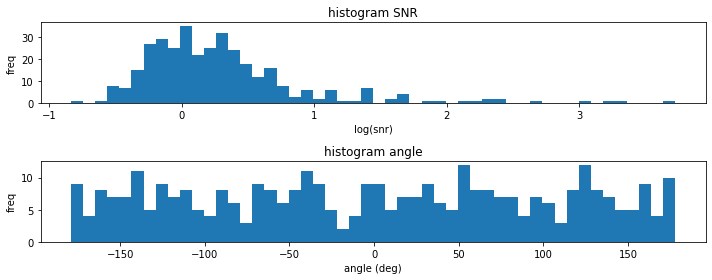

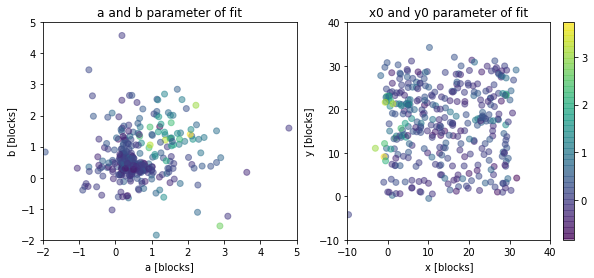

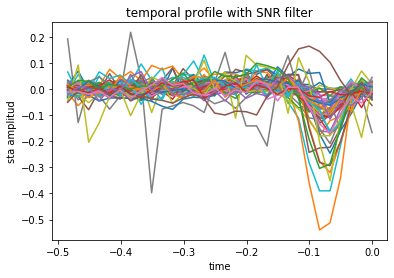

In [4]:
with h5py.File(processed_file, 'r') as protocols:
    raw_temp = protocols[f'/sta/{intensity}/temporal/raw/']
    raw_char = protocols[f'/sta/{intensity}/spatial/char/']
    temp_char = np.array([raw_temp[kunit][:] for kunit in raw_temp])
    spatial_char = np.array([raw_char[kunit][:] for kunit in raw_char])
    time_raw_temp = protocols[f'/sta/{intensity}/temporal/raw/'].attrs['time']
    

f, ax = plt.subplots(2, 1, figsize=(10, 4))
ax[0].hist(np.log(spatial_char[:,-2]), bins=50);
ax[1].hist(spatial_char[:,0], bins=50);
ax[0].set(title='histogram SNR', xlabel='log(snr)', ylabel='freq')
ax[1].set(title='histogram angle', xlabel='angle (deg)', ylabel='freq')
f.tight_layout()
f.savefig(output_file + 'histogram_snr_angle_{}.png'.format(intensity))

f, ax = plt.subplots(1, 2, figsize=(10, 4))
cc = ax[0].scatter(spatial_char[:, 1], spatial_char[:, 2], c=np.log(spatial_char[:, -2]), alpha=0.5)
cc = ax[1].scatter(spatial_char[:, 3], spatial_char[:, 4], c=np.log(spatial_char[:, -2]), alpha=0.5)
ax[0].set(title='a and b parameter of fit', xlabel='a [blocks]', ylabel='b [blocks]', xlim=(-2,5), ylim=(-2,5))
ax[1].set(title='x0 and y0 parameter of fit', xlabel='x [blocks]', ylabel='y [blocks]', xlim=(-10,40), ylim=(-10,40))
f.colorbar(cc)
f.savefig(output_file + 'snr_vs_fit_{}.png'.format(intensity))


f, ax = plt.subplots()
ax.plot(time_raw_temp, temp_char[(spatial_char[:, -2] > 2), :].T);
ax.set(title='temporal profile with SNR filter', xlabel='time', ylabel='sta amplitud')
f.savefig(output_file + 'temporal_RF_with_snr_filter_{}.png'.format(intensity))
